In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings
from typing import Tuple
from pathlib import Path
from copy import deepcopy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import plotly.express as px

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

sys.path.append("/app")
from visualizations.scripts.drawer import metric_viewer, russia_plots, russia_plots_n
from scripts.processing import read_table_gauge_str

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


def get_silhouette_scores(features: np.ndarray) -> Tuple[dict]:
    """Calculate the mean and min silhouette score of a range of possible cluster numbers.

    Parameters
    ----------
    features : np.ndarray
        Array containing the input features.

    Returns
    -------
    mean_scores : dict
        Dictionary containing the mean silhouette scores for each cluster number
    min_scores : dict
        Dictionary containing the min silhouette scores for each cluster number

    """
    mean_scores, min_scores = {}, {}
    min_scores = {}
    for n_clusters in range(3, 20, 1):
        clusterer = KMeans(n_clusters=n_clusters, random_state=0, init="k-means++")
        cluster_labels = clusterer.fit_predict(features)
        silhouette_scores = silhouette_samples(
            X=features, labels=cluster_labels, metric="euclidean"
        )
        mean_scores[n_clusters] = np.mean(silhouette_scores)
        min_scores[n_clusters] = np.min(silhouette_scores)

    return mean_scores, min_scores


def get_high_silhoute(input_df: pd.DataFrame):
    clusters_range = range(2, 21)
    silhoute_result = dict()
    # data = pca95(input_df)
    data = input_df

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhoute_result[i] = silhouette_avg

    fig, ax = plt.subplots(figsize=(15, 8))

    x = list(silhoute_result.keys())
    y = list(silhoute_result.values())

    ax.plot(x, y, "-")
    line_x = x[np.argmax(y)]
    ax.axvline(x=line_x, color="r")

    ax.set_xlabel("Количество кластеров, шт.", fontsize=14)
    ax.set_ylabel("Величина силуэта", fontsize=14)
    ax.set_title(
        f"Максимальная величина силуэта найдена для {line_x} кластеров", fontsize=14
    )
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs=[i for i in range(1, 21)]))
    ax.set_xticklabels([f"{i}" for i in range(1, 21)])

    plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    ax.grid(False)
    plt.show()

    return fig

### Read necessary geometry

In [44]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.drop([26, 27])
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

### Use only gauges from LSTM model

In [47]:
hbv_table = pd.read_csv(
    "./tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
gr4j_table = pd.read_csv(
    "./tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "./tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_table = pd.read_csv(
    "./tables/cudalstm_q_mm_day_mswep_res.csv",
    index_col="Unnamed: 0",
    dtype={"gauge_id": str},
)
lstm_table.index = lstm_table.index.astype(str)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_table.index)
    .intersection(ws_file.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file['size'] = np.nan
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### Area plot distribution

In [ ]:
gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="size",
    # cmap_name='tab20',
    #   metric_col='Кластер',
    # list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=True,
)

### Geo-clusters

In [54]:
static_attrs = pd.read_csv("../geo_data/static_data.csv")
static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")
# adjust indexes in accordance to size of data
static_attrs = static_attrs.loc[common_index, :]

static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]

russian_names = {
    "for_pc_sse": "Лесистость",
    "crp_pc_sse": "Пахотные земли",
    "inu_pc_ult": "Затапливаемые территории",
    "ire_pc_sse": "Орошаемые территории",
    "lka_pc_use": "Озерность",
    "prm_pc_sse": "Мерзлотные территории",
    "pst_pc_sse": "Пастбища",
    "cly_pc_sav": "Глинистость",
    "slt_pc_sav": "Осадочные породы",
    "snd_pc_sav": "Песчаные породы",
    "kar_pc_sse": "Карстовые породы",
    "urb_pc_sse": "Урбанизированные территории",
    "gwt_cm_sav": "Глубина первого водоносного горизонта",
    "lkv_mc_usu": "Объём озёр",
    "rev_mc_usu": "Объём водохранилищ",
    "ws_area": "Площадь водосбора",
    "ele_mt_sav": "Средняя высота водосбора",
}
# static_attrs = static_attrs[static_parameters]
static_norm = (static_attrs - static_attrs.mean()) / static_attrs.std()
static_norm = static_norm.dropna(axis=1)
raw_features = static_norm.values

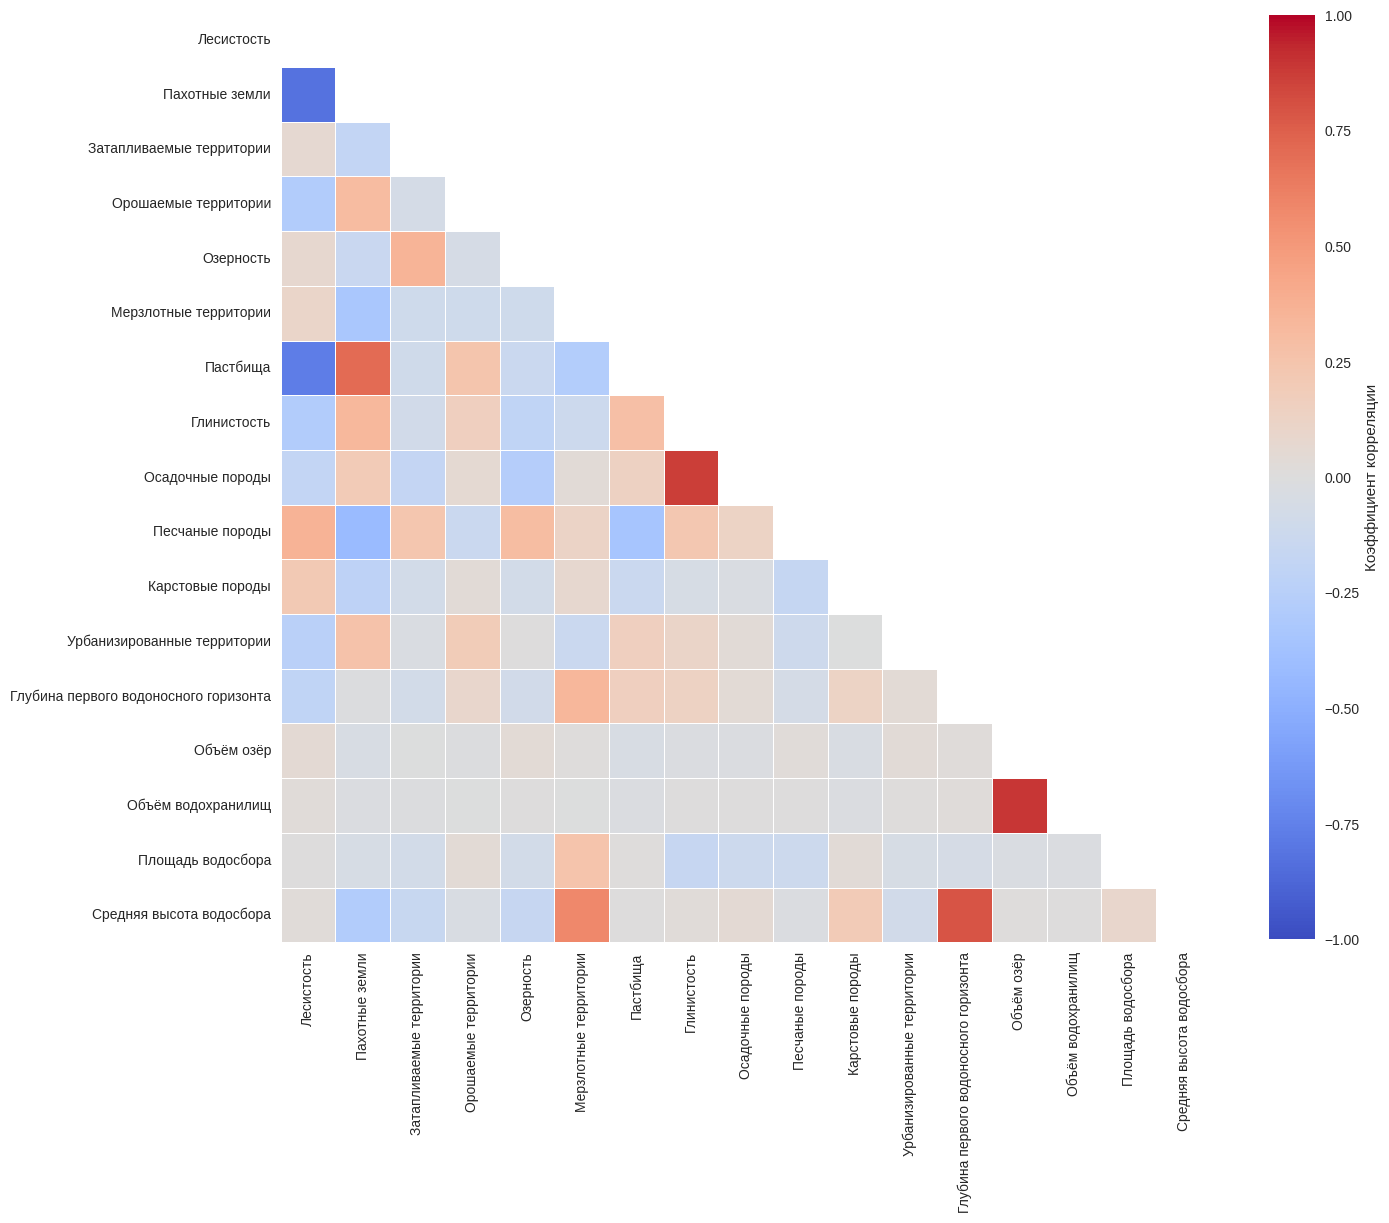

In [50]:
correlation_matrix = static_norm.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
)
correlation_matrix.columns = [russian_names[i] for i in correlation_matrix.columns]
correlation_matrix.index = [russian_names[i] for i in correlation_matrix.index]
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    ax=ax,
    robust=True,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8,
              "label": "Коэффициент корреляции"},
);
# plt.xticks(rotation=5);

In [51]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,24), timings=True)
visualizer.fit(raw_features)        # Fit data to visualizer
visualizer.show();

In [55]:
number_of_clusters = 9

# cluster_alg = SpectralClustering(
#     n_clusters=number_of_clusters,
#     random_state=42,
#     # affinity="rbf",
#     assign_labels="kmeans",
#     n_neighbors=static_norm.__len__() // number_of_clusters,
# )
cluster_alg = KMeans(
    n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420
)
# cluster_alg = AgglomerativeClustering(
#     n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
# )

yhat_AC = cluster_alg.fit_predict(raw_features)
static_norm["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.nan
static_attrs["ResClust"] = np.nan

gauges_file = gauges_file.combine_first(static_norm).dropna()
static_attrs = static_attrs.combine_first(static_norm).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True)

In [57]:
polar


,Кластер,variable,value
0,1,Лесистость,0.420309
1,2,Лесистость,0.377584
2,3,Лесистость,0.161339
3,4,Лесистость,-1.413010
4,5,Лесистость,-0.769022
...,...,...,...
148,5,Средняя высота водосбора,2.887387
149,6,Средняя высота водосбора,-0.539585
150,7,Средняя высота водосбора,0.081851
151,8,Средняя высота водосбора,-0.345543


In [60]:
g_clust


,for_pc_sse,crp_pc_sse,inu_pc_ult,ire_pc_sse,lka_pc_use,prm_pc_sse,pst_pc_sse,cly_pc_sav,slt_pc_sav,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,ws_area,ele_mt_sav
Кластер,,,,,,,,,,,,,,,,,
9,0.181176,-0.726108,0.814197,-0.251405,-0.17023,0.021209,-0.73256,-0.31062,0.288382,0.130713,-0.519571,-0.298154,0.332673,-0.063971,-0.035523,-0.532402,-0.092967


In [61]:
cluster_stats = list()
for i, group_id in static_norm.groupby("ResClust").groups.items():
    g_clust = static_norm.loc[group_id, static_parameters].mean().to_frame().T
    g_clust.index = [i]
    g_clust.index.name = "Кластер"
    cluster_stats.append(g_clust)
cluster_stats = pd.concat(cluster_stats)
cluster_stats = cluster_stats.reset_index()
cluster_stats

,Кластер,for_pc_sse,crp_pc_sse,inu_pc_ult,ire_pc_sse,lka_pc_use,prm_pc_sse,pst_pc_sse,cly_pc_sav,slt_pc_sav,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,ws_area,ele_mt_sav
0,1,0.420309,-0.152729,-0.163618,-0.079179,0.012157,-0.448551,-0.195559,-0.153499,-0.102410,0.166112,0.139868,0.111918,-0.464679,-0.045395,-0.031033,-0.213567,-0.436126
1,2,0.377584,-0.372758,0.085787,-0.234567,-0.200972,0.282615,-0.123459,-0.049153,0.085535,-0.106814,0.065606,-0.195991,-0.264751,0.017308,-0.032153,0.310605,0.309385
2,3,0.161339,-0.717974,-0.257650,-0.251405,-0.263696,2.610123,-0.707068,-0.338544,-0.012388,0.400411,0.141430,-0.320314,1.060000,-0.028805,-0.035361,0.515040,1.484375
3,4,-1.413010,1.657341,-0.297255,0.382908,-0.242098,-0.482936,1.047047,0.606347,0.463610,-0.708991,-0.361683,0.405625,-0.152243,-0.063680,-0.030515,-0.080758,-0.480275
4,5,-0.769022,-0.296858,0.272241,0.536593,-0.354172,0.094497,1.162010,0.692549,0.044645,-0.432258,1.046483,0.242066,3.379356,-0.073462,-0.035325,-0.255237,2.887387
5,6,0.620790,-0.705917,0.431875,-0.251404,1.098243,-0.141611,-0.728300,-0.650080,-0.760266,0.882769,-0.085826,-0.294068,-0.522217,0.234250,0.204008,0.041991,-0.539585
6,7,0.853085,-0.614185,-0.190632,-0.035116,-0.292291,-0.315447,-0.598596,0.147410,0.117643,-0.077851,0.390714,-0.127979,0.232731,-0.073175,-0.035447,-0.142431,0.081851
7,8,-1.765562,1.675618,-0.346488,1.331365,-0.257889,-0.482236,1.925868,0.935816,0.149945,-0.701421,-0.387815,0.661120,1.034980,-0.060483,-0.024003,-0.030776,-0.345543
8,9,0.181176,-0.726108,0.814197,-0.251405,-0.170230,0.021209,-0.732560,-0.310620,0.288382,0.130713,-0.519571,-0.298154,0.332673,-0.063971,-0.035523,-0.532402,-0.092967


In [ ]:
polar = pd.melt(cluster_stats, id_vars=["Кластер"])
polar["variable"] = [russian_names[i] for i in polar["variable"]]

cmap_name: str = "turbo"
cmap = cm.get_cmap(cmap_name, number_of_clusters)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

fig_polar = px.line_polar(
    polar,
    r="value",
    theta="variable",
    color="Кластер",
    color_discrete_sequence=color_list,
    template="seaborn",
    height=900,
    width=1500,
)
fig_polar.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=""),
        angularaxis=dict(showticklabels=True, tickangle=0),
    ),
    legend_title_text="Кластеры",
    # legend_title_text=None,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0,
    ),
)
# fig_polar.write_image("./images/cluster_importance_tft.png")
plt.tight_layout()
fig_polar


### Hydro-clusters

#### Median discharges across period of observation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

q_df = pd.DataFrame()

for i, gauge_id in enumerate(common_index):
    q_df["gauge_id"] = np.nan
    with xr.open_dataset(f"../geo_data/ws_related_meteo/nc_all_q/{gauge_id}.nc") as f:
        yearly_file = f.to_dataframe()
        yearly_average = (
            yearly_file[["q_mm_day"]]
            .groupby([yearly_file.index.month, yearly_file.index.day])
            .median()
            .values.ravel()
        )
    q_df.loc[:, gauge_id] = yearly_average.copy()

q_df = q_df.loc[:, q_df.max() < 100]
q_df_clust = deepcopy(q_df.T)
q_df_clust.columns = q_df_clust.columns.astype(str)
gauges_clust = deepcopy(gauges_file)
min_max_scaler = MinMaxScaler()
q_df_clust.loc[:, :] = min_max_scaler.fit_transform(q_df_clust.values)


#  Add gauge lat lon
for gauge_id in tqdm(q_df_clust.index):
    for i in range(1):
        q_df_clust.loc[gauge_id, f"lat_{i}"] = gauges_clust.loc[gauge_id, "geometry"].x
        q_df_clust.loc[gauge_id, f"lon_{i}"] = gauges_clust.loc[gauge_id, "geometry"].y

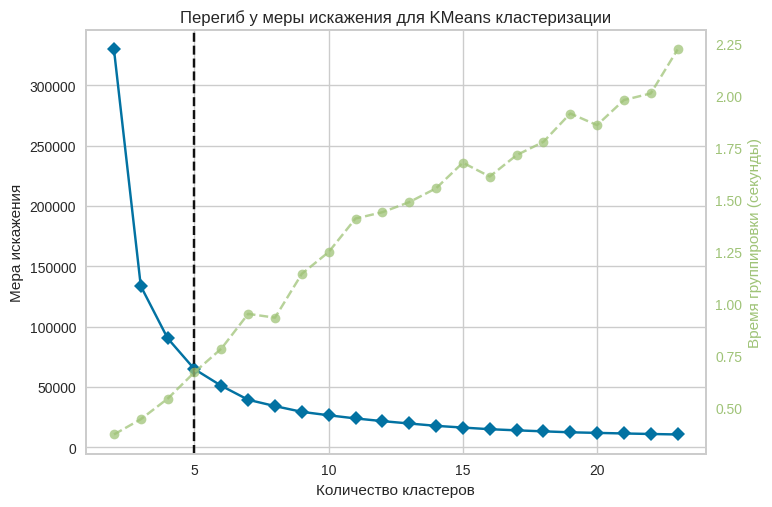

In [15]:
df_norm = deepcopy(q_df_clust)
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42, init="k-means++", n_init=420)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,24), timings=True)
visualizer.fit(df_norm.values)        # Fit data to visualizer
visualizer.show();

In [93]:
number_of_clusters = 9

cluster_alg = KMeans(
    n_clusters=number_of_clusters,
    random_state=42,
    init="k-means++", n_init=420
)

yhat_AC = cluster_alg.fit_predict(df_norm.values)

df_norm["ResClust"] = [i + 1 for i in yhat_AC]

# bad_clusters = list()

for i, idx in df_norm.groupby("ResClust").groups.items():
    print(f"для {i} нашлось {len(idx)} объектов")
    # if len(idx) < 5:
    #     bad_clusters.append(i)

# df_norm = df_norm.loc[~df_norm["ResClust"].isin(bad_clusters), :]


gauges_clust["ResClust"] = np.nan

gauges_clust = gauges_clust.combine_first(df_norm).dropna()
gauges_clust["Кластер"] = [f"Кластер {int(i)}" for i in gauges_clust["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_clust,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    list_of_limits=list(range(1, number_of_clusters)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=False)

для 1 нашлось 157 объектов
для 2 нашлось 175 объектов
для 3 нашлось 114 объектов
для 4 нашлось 181 объектов
для 5 нашлось 103 объектов
для 6 нашлось 141 объектов
для 7 нашлось 27 объектов
для 8 нашлось 71 объектов
для 9 нашлось 43 объектов


In [88]:
cluster_q_mm = dict()
for clust_id, group_id in gauges_clust.groupby("Кластер").groups.items():
    cluster_q_mm[clust_id] = list()
    cluster_q_mm[clust_id]= gauges_clust.loc[group_id, list(map(str, range(0, 366)))].T
    cluster_q_mm[clust_id].index = pd.date_range(start='01/01/2000', end='12/31/2000')

q_fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, (clust_ax, (clust_id, clust_data)) in enumerate(zip(ax.flatten(), cluster_q_mm.items())):
    clust_avg = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day])
        .mean()
        .reset_index(drop=True)
        .median(axis=1)
        .values.ravel()
    )

    mean_by_gauge = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day])
        .median()
        .reset_index(drop=True)
    )

    # Define a consistent color and transparency level
    line_color = "blue"  # Example color
    line_alpha = 0.2  # Transparency level (0.0 to 1.0)

    for gauge_id in mean_by_gauge.columns:
        clust_ax.plot(
            mean_by_gauge.index.values,
            mean_by_gauge[f"{gauge_id}"].values,
            color=line_color,
            alpha=line_alpha,
            linewidth=0.5,
        )
    clust_ax.plot(mean_by_gauge.index.values, clust_avg, color="red", alpha=1.0)
    # Hide grid lines
    clust_ax.grid(axis='both', which='both')
    clust_ax.set_xlim(left=0, right=365)
    
    clust_ax.set_ylim(bottom=0, top=1)
    clust_ax.set_yticks(np.arange(0, 1.25, .25))
    clust_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if i in [0, 4]:
        clust_ax.set_ylabel("Модуль стока, мм/сут.")
    # if i in [5, 6, 7, 8]:
    clust_ax.set_xlabel("Дней от начала года, сут.")

    for val in np.arange(0, 1.25, .25):
        clust_ax.axhline(val, c="black", linestyle="--", linewidth=0.2)
    clust_ax.set_title(f"Кластер {clust_id} - {len(clust_data.columns)} постов")
    clust_ax.set_xticks([0, 90, 180, 270, 365])
q_fig.tight_layout()

In [98]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# Create a figure
fig = plt.figure(figsize=(15, 20))

# Define the GridSpec
gs = gridspec.GridSpec(5, 3)  # n row, m columns

###############################################################################
aea_crs = ccrs.AlbersEqualArea(
    central_longitude=100,
    standard_parallels=(50, 70),
    central_latitude=56,
    false_easting=0,
    false_northing=0,
)
# to proj4 form
aea_crs_proj4 = aea_crs.proj4_init

gdf_to_plot=gauges_clust
basemap_data=basemap_data
distinction_col="Кластер"
cmap_name="turbo"
list_of_limits=list(range(1, number_of_clusters))
just_points=True
with_histogram=False
cmap = cm.get_cmap(cmap_name, 18)

# Create spatial clusters , subplot_kw={"projection": aea_crs}
ax1 = plt.subplot(gs[:2, :])
ax1.set_aspect("equal")
ax1.axis("off")
# ax1.set_extent(rus_extent)  # type: ignore
basemap_data.to_crs(aea_crs_proj4).plot(  # type: ignore
    ax=ax1, color="grey", edgecolor="black", legend=False, alpha=0.8
)
gdf_to_plot = gdf_to_plot.to_crs(aea_crs_proj4)  # type: ignore
scatter_plot = gdf_to_plot.plot(
    ax=ax1,
    column=distinction_col,
    cmap=cmap,
    marker="o",
    markersize=20,
    legend=True,
    legend_kwds={
        "ncol": 3,
        "loc": "lower left",
        "fmt": "{:.0f}",
        "fontsize": 14,
        "markerscale": 0.5,
        "frameon": True,
    },
)

# Create the second subplot
# ax2 = plt.subplot(gs[2:, :])
# Add subplots
axs = [fig.add_subplot(gs[i, j]) for i in range(2, 5) for j in range(3)]

for i, (clust_ax, (clust_id, clust_data)) in enumerate(zip(axs, cluster_q_mm.items())):

    clust_mean = clust_data.groupby([clust_data.index.month, clust_data.index.day]).mean().reset_index(drop=True)
    
    # clust_avg = (
    #     clust_data.groupby([clust_data.index.month, clust_data.index.day])
    #     .mean()
    #     .reset_index(drop=True)
    #     .median(axis=1)
    #     .values.ravel()
    # )

    # mean_by_gauge = (
    #     clust_data.groupby([clust_data.index.month, clust_data.index.day])
    #     .mean()
    #     .reset_index(drop=True)
    # )
    # mean_by_gauge = clust_mean / clust_mean_by_gauge
    # Define a consistent color and transparency level
    line_color = "blue"  # Example color
    line_alpha = 0.2  # Transparency level (0.0 to 1.0)
    clust_avg = clust_mean.median(axis=1).values.ravel()
    for gauge_id in clust_mean.columns:
        clust_ax.plot(
            clust_mean.index.values,
            clust_mean[f"{gauge_id}"].values,
            color=line_color,
            alpha=line_alpha,
            linewidth=0.5,
        )
    clust_ax.plot(clust_mean.index.values, clust_avg, color="red", alpha=1.0)
    # Hide grid lines
    clust_ax.grid(axis='both', which='both')
    clust_ax.set_xlim(left=0, right=365)

    # interval_step = np.max(clust_mean) / 5 + 1
    # y_ticks = np.arange(0, np.max(clust_mean) + interval_step, interval_step)
    y_ticks = np.arange(0, 1.25, .25)
    clust_ax.set_ylim(0, 1)
    clust_ax.set_yticks(y_ticks)
    clust_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if i in [0, 3, 6]:
        clust_ax.set_ylabel("Нормированный модуль стока")
    # if i in [5, 6, 7, 8]:
    clust_ax.set_xlabel("Дней от начала года, сут.")

    for val in y_ticks:
        clust_ax.axhline(val, c="black", linestyle="--", linewidth=0.2)
    clust_ax.set_title(f"{clust_id} - {len(clust_data.columns)} шт.")
    clust_ax.set_xticks([0, 90, 180, 270, 365])

ax1.text(0.0, 0.95, 'а)', transform=ax1.transAxes, 
         fontsize=16, va='center', ha='center', 
         bbox=dict(facecolor='white', alpha=0.5))
axs[0].text(0.0, 1.2, 'б)', transform=axs[0].transAxes, 
         fontsize=16, va='center', ha='center', 
         bbox=dict(facecolor='white', alpha=0.5))
# Adjust layout
plt.tight_layout()

In [304]:
np.max(mean_by_gauge)

2.9538958416024736

In [247]:
gauges_clust.to_file("tables/Q_clustering.gpkg")

In [262]:
gauges_file.to_file("tables/HydroATLAS_clustering.gpkg")